In [15]:
%load_ext autoreload
%autoreload 2
import data_manipulation
import pickle
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
import os
from skimage.exposure import adjust_sigmoid
from skimage import feature
from skimage.color import rgb2gray
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data_manipulation.datset_split()

AttributeError: module 'data_manipulation' has no attribute 'datset_split'

In [17]:
with open("data/dataset_train.obj", "rb") as f:
    train = pickle.load(f)

# Healthy Lung

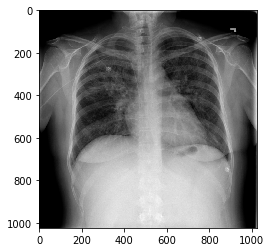

In [18]:
mask, class_ids = train.load_mask(0)
image = train.load_image(0)
plt.imshow(image)
plt.show()

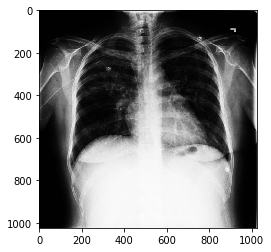

In [19]:
threshold_image = adjust_sigmoid(image)
plt.imshow(threshold_image)
plt.show()

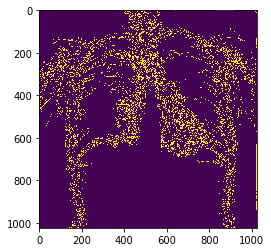

In [20]:
edge_detected = feature.canny(rgb2gray(threshold_image), sigma = 0.5)
plt.imshow(edge_detected)
plt.show()

# Lung Opacity

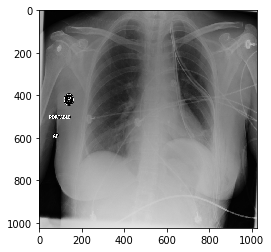

In [21]:
image_id = 15
mask, class_ids = train.load_mask(image_id)
image = train.load_image(image_id)
plt.imshow(image)
plt.show()

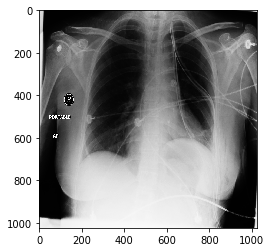

In [22]:
threshold_image = adjust_sigmoid(image)
plt.imshow(threshold_image)
plt.show()

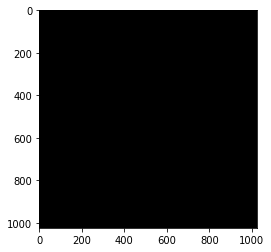

In [23]:
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')

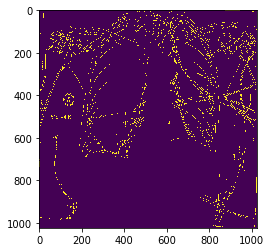

In [24]:
edge_detected = feature.canny(rgb2gray(threshold_image), sigma = 0.6)
plt.imshow(edge_detected)
plt.show()

In [26]:
def prior():
    ids = range(train.size())
    sample = random.sample(ids, 20)
    cnt_box = np.zeros([1024,1024,1])

    p_imgs = [] #build up list of masks (numpy array) of images with pneumonia
    hasPneu = 0
    for id in sample[:]:
        mask, class_ids = train.load_mask(id) #mask = numpy array of boolean values. 1 if pneumonia in that pixel
                   #class_ids = 1 elt array. 1 if image has pneumonia. 0 otherwise
        if (class_ids.all()):
            hasPneu += 1
            #np.sum
            cnt_box = cnt_box + np.sum(mask.astype(int), axis = 2)
    print(cnt_box.shape)
    x = np.max(cnt_box)
    return hasPneu, x, cnt_box

In [57]:
IMAGE_DIM = 1024
SCALE = 1.2

In [104]:
def probability_distribution(image_id, width, height, scale, x, y):
    #maximum_distance is the maximum distance from the edge of the bounding box for the probability to be calculated
    #width is the width of the bounding box
    #height is the height of the bounding box
    #x is the xth pixel where the center of the bounding box is
    #y is the yth pixel where the center of the bounding box is
    #bounding boxes defined by x-min y-min???
    center_x = int(x+width/2)
    center_y = int(y+height/2)
    max_radius = int(np.sqrt((height/2)**2 + (width/2)**2))

    #assume cv2 used to load image
    x_dim = IMAGE_DIM
    y_dim = IMAGE_DIM
    new_image = np.zeros(shape=(x_dim,y_dim))
    
    for xi in range (int(-scale*width/2), int(scale*width/2)):
        for yi in range (int(-scale*height/2), int(scale*height/2)):
            r = np.sqrt((xi)**2 + (yi)**2)
            probability = 1.0-(r/(scale*max_radius))
            probability = 0 if probability < 0 else probability
            x_new_image = (center_x + xi)
            y_new_image = (center_y + yi)
            if(x_new_image > -1 and x_new_image < x_dim and y_new_image > -1 and y_new_image < y_dim ):
                new_image[x_new_image][y_new_image] = round(probability, 2) 
    
    return new_image
                
    

In [126]:
def getProbDist(image_id, scale):
    pneu = 0
    info = train.image_info[image_id]
    x_dim = IMAGE_DIM
    y_dim = IMAGE_DIM
    probDist = np.zeros(shape=(x_dim,y_dim))
    annotations = info['annotations']
    if(len(annotations) > 0):
        patientId = annotations[0].patientId
        for a in annotations:
            if a['Target'] == 1:
                x = int(a['x'])
                y = int(a['y'])
                w = int(a['width'])
                h = int(a['height'])
                probDist += probability_distribution(image_id, h, w, scale, y, x)
        np.clip(probDist, 0, 1)
    return probDist